In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import csv
import os
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

In [2]:
import random
import tensorflow as tf

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Cleaning 

In [79]:
google_data = pd.read_csv('C:/Users/mckay/6300-Data-Project/full_complete_datasets/GOOG_raw_complete_data.csv')

print(google_data.head())

         date  GOOG_close  GOOG_high  GOOG_low  GOOG_open  GOOG_traded_volume  \
0  2014-03-27      558.46     568.00    552.92    568.000               13100   
1  2014-03-28      559.99     566.43    558.67    561.200               41100   
2  2014-03-31      556.97     567.00    556.93    566.890               10800   
3  2014-04-01      567.16     568.45    558.71    558.710                7900   
4  2014-04-02      567.00     604.83    562.19    565.106              146700   

   GOOG_adjClose  GOOG_adjLow  GOOG_adjOpen  GOOG_adj_traded_volume  ...  \
0      27.822745    27.546739     28.298032                  262000  ...   
1      27.898970    27.833207     27.959253                  822000  ...   
2      27.748512    27.746519     28.242731                  216000  ...   
3      28.256183    27.835200     27.835200                  158000  ...   
4      28.248212    28.008575     28.153852                 2934000  ...   

   NVDA_traded_volume  NVDA_adjClose NVDA_adjLow NVDA_ad

In [80]:
# These columns just represents the company's symbol and currency labels and is not useful so we drop it
google_data.drop(columns= ['symbol', 'CADUSD_label', 'KRWUSD_label', 'CNHUSD_label', 'GBPUSD_label', 'JPYUSD_label', 'EURUSD_label', 'CHFUSD_label', 'sector', 'exchange'], inplace=True)

In [81]:
#checking duplicate rows
duplicates = google_data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

print(google_data[duplicates])

Number of duplicate rows: 42
            date  GOOG_close  GOOG_high   GOOG_low  GOOG_open  \
92    2014-07-31      571.60   583.6499   570.0000     580.60   
93    2014-07-31      571.60   583.6499   570.0000     580.60   
157   2014-10-29      549.33   554.1900   546.9800     550.00   
158   2014-10-29      549.33   554.1900   546.9800     550.00   
159   2014-10-29      549.33   554.1900   546.9800     550.00   
285   2015-04-27      555.37   565.9500   553.2001     563.39   
286   2015-04-27      555.37   565.9500   553.2001     563.39   
287   2015-04-27      555.37   565.9500   553.2001     563.39   
924   2017-10-13      989.68   997.2100   989.0000     992.00   
925   2017-10-13      989.68   997.2100   989.0000     992.00   
1117  2018-07-10     1152.84  1159.5900  1149.5900    1156.98   
1118  2018-07-10     1152.84  1159.5900  1149.5900    1156.98   
1367  2019-07-05     1131.59  1132.8800  1116.1400    1117.80   
1368  2019-07-05     1131.59  1132.8800  1116.1400    1117.80

## Filling Na Data

In [82]:
# Calculate percentage of missing values for each column
missing_percentages = (google_data.isnull().sum() / len(google_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

pe                                          0.775194
basicMaterialsChangesPercentage           100.000000
communicationServicesChangesPercentage     23.819591
consumerCyclicalChangesPercentage          23.819591
consumerDefensiveChangesPercentage         23.819591
                                             ...    
standardDeviation                           0.070472
tema                                        0.070472
williams                                    0.070472
wma                                         0.070472
NVDA_twitter_social_sentiment              97.780127
Length: 112, dtype: float64


In [83]:
import seaborn as sns

#checking the perecnt of missing data
def percent_missing(google_data):
    nan_percent = 100 * google_data.isnull().sum() / len(google_data)
    nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

    return nan_percent

#plot to show the columns missing data
def show_percent_missing(google_data):
    nan_percent = percent_missing(google_data)

    plt.figure(figsize=(24, 8))

    sns.barplot(x=nan_percent.index, y=nan_percent)
    plt.xticks(rotation=90)
    plt.ylabel('Missing Percentage %')
    plt.xlabel('Variables')

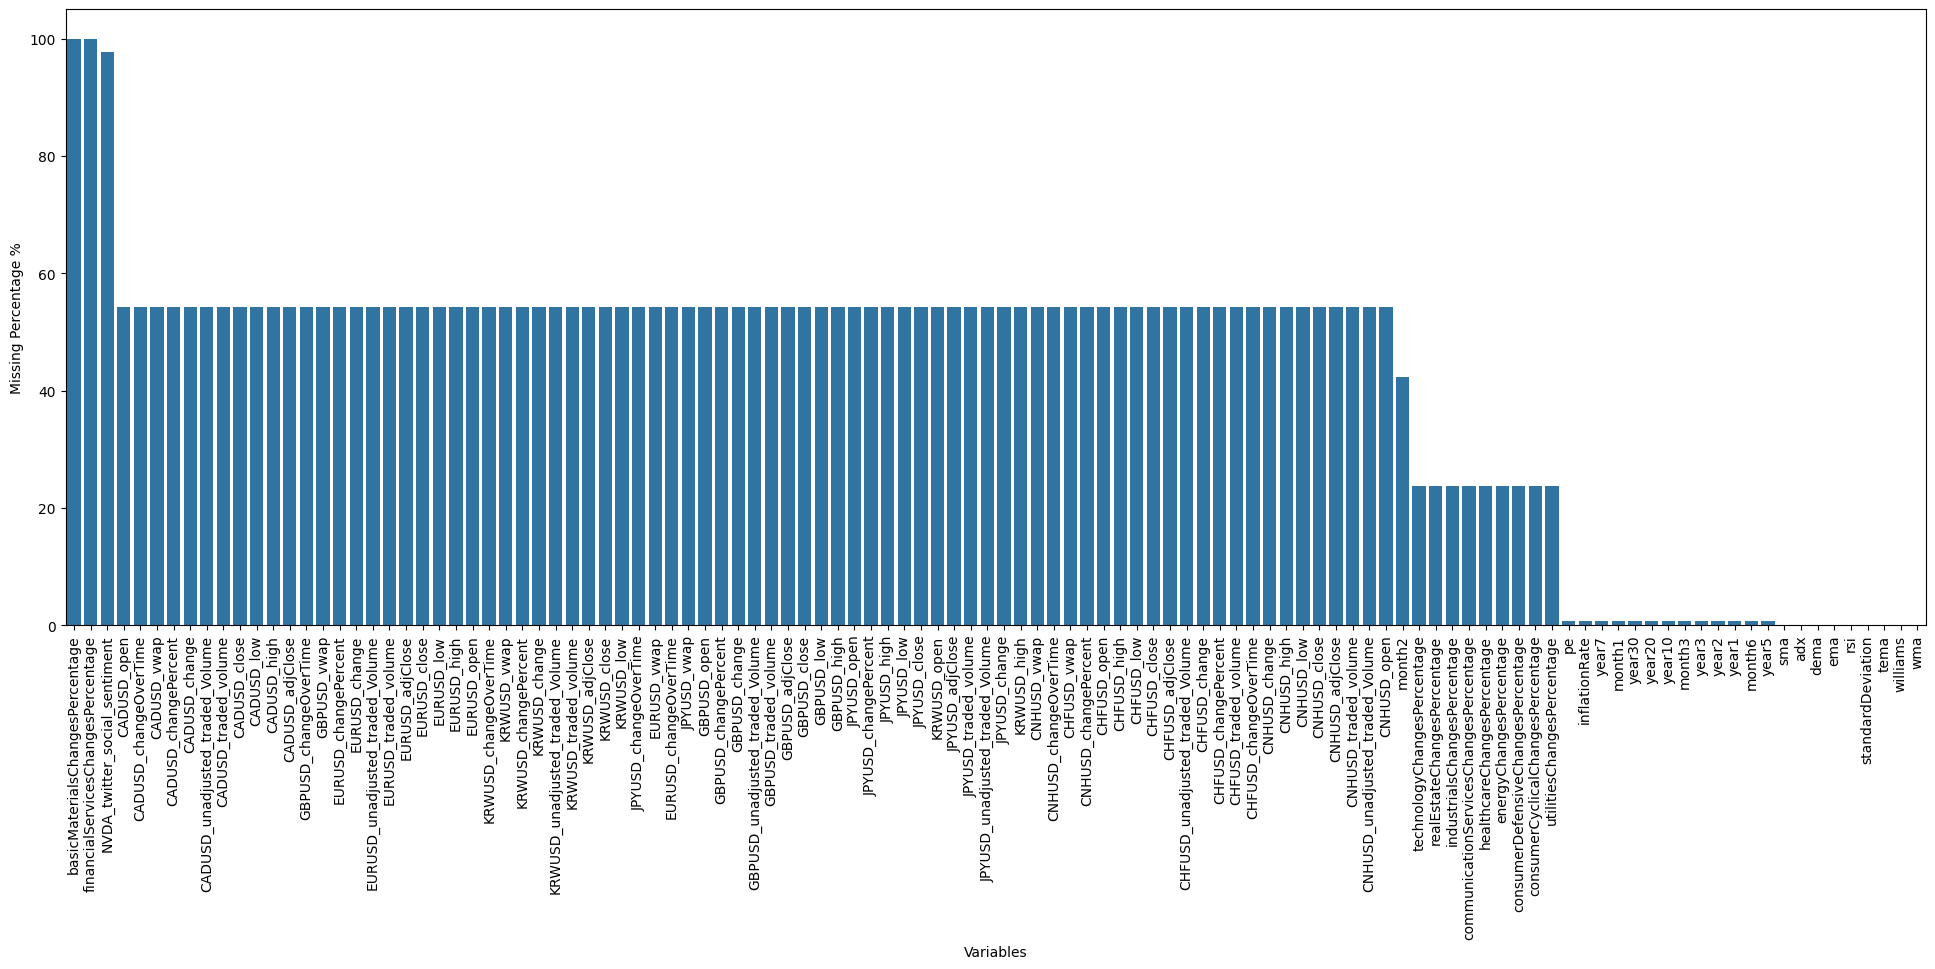

In [8]:
show_percent_missing(google_data)

In [84]:
#removing columns with over 75% missing data
cols_to_remove = [col for col in google_data.columns if google_data[col].isnull().mean() * 100 >= 75]

print("Columns removed due to more than 75% missing values:")
print(cols_to_remove)

#dropping the columns with high missing data
google_data = google_data.drop(columns=cols_to_remove)


Columns removed due to more than 75% missing values:
['basicMaterialsChangesPercentage', 'financialServicesChangesPercentage', 'NVDA_twitter_social_sentiment']


In [85]:
#filling the columns with 1% or less missing data with the mode of their columns

#finding all the columns with very little missing data
vsmall_missing_cols = [col for col in google_data.columns if google_data[col].isnull().mean() * 100 <= 1]

#filling missing values with mode for each identified column
for col in vsmall_missing_cols:
    google_data[col].fillna(google_data[col].mode()[0], inplace=True)

print(f"Filled missing values in {len(vsmall_missing_cols)} columns using mode.")

Filled missing values in 69 columns using mode.


C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\2418404856.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  google_data[col].fillna(google_data[col].mode()[0], inplace=True)
C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\2418404856.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [96]:
#converting date to time series
google_data['date'] = pd.to_datetime(google_data['date'])
google_data.set_index('date', inplace=True)

#add 'year' and 'month' columns to use for averages
google_data['year'] = google_data.index.year
google_data['month'] = google_data.index.month

C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\565108283.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  google_data['year'] = google_data.index.year
C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\565108283.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  google_data['month'] = google_data.index.month


In [86]:
# Identify columns containing either 'changesPercent' or 'ChangesPercentage' 

#filling the columns with changepercent or changesoercentage
changes_percent_cols = [col for col in google_data.columns if 'changespercent' in col.lower() or 'changespercentage' in col.lower()]

# Apply rolling mean, then forward-fill and backward-fill as a backup
for col in changes_percent_cols:
    #using a rolling mean to fill as many of the NaNs as possible
    google_data[col] = google_data[col].rolling(window=7, min_periods=1).mean()
    #whatever the rolling mean can't fill- interpolate   
    google_data[col] = google_data[col].interpolate(method='linear', limit_direction='both')
    mask_nan = google_data[col].isna()
    if google_data[col].isna().sum() > 0:
        #fill remaining NaNs using the average for each year-month group if the rolling mean and interpolating can't fill gaps
        monthly_avg = google_data.groupby(['year', 'month'])[col].transform('mean')
        google_data[col] = google_data[col].fillna(monthly_avg)
    google_data[col] = google_data[col].fillna(google_data[col].mean())

print(f"All missing values in {len(changes_percent_cols)} columns have been filled.")


All missing values in 9 columns have been filled.


In [87]:
# Identify currency exchange rate columns
currency_cols = [col for col in google_data.columns if 'USD' in col]

# Apply forward-fill, backward-fill, and interpolation
for col in currency_cols:
    google_data[col] = google_data[col].rolling(window=5, min_periods=1).mean()  # Apply rolling mean
    google_data[col] = google_data[col].interpolate(method='linear')  # Interpolation for gradual trends
    google_data[col] = google_data[col].fillna(method='ffill')  # Forward-fill to propagate last known value
    google_data[col] = google_data[col].fillna(method='bfill') 

# Print confirmation
print(f"Filled missing values in {len(currency_cols)} currency exchange rate columns using forward-fill, backward-fill, and interpolation.")


C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\2531207910.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_data[col] = google_data[col].fillna(method='ffill')  # Forward-fill to propagate last known value
C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\2531207910.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_data[col] = google_data[col].fillna(method='bfill')


Filled missing values in 77 currency exchange rate columns using forward-fill, backward-fill, and interpolation.


In [88]:
# Compute correlation of all columns with 'SalePrice'
correlations = google_data.corr(numeric_only=True)['month2'].sort_values(ascending=False)

# Show the correlations
print(correlations)


month2               1.000000
month3               0.999170
month1               0.997220
month6               0.992178
year1                0.978478
                       ...   
GOOG_low            -0.890700
GOOG_open           -0.890858
GOOG_close          -0.891301
GOOG_high           -0.891581
standardDeviation         NaN
Name: month2, Length: 151, dtype: float64


In [89]:
from sklearn.linear_model import LinearRegression

#filling month 2 with a linear regression based off month 3
train = google_data[google_data['month2'].notna() & google_data['month3'].notna()]
test = google_data[google_data['month2'].isna() & google_data['month3'].notna()]

#training linear regression model
model = LinearRegression()
model.fit(train[['month3']], train['month2'])

#predicting missing Month_2 values
predicted_values = model.predict(test[['month3']])

#filling in the missing values
google_data.loc[google_data.index.isin(test.index), 'month2'] = predicted_values

In [90]:
# Calculate percentage of missing values for each column
missing_percentages = (google_data.isnull().sum() / len(google_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

Series([], dtype: float64)


In [91]:
print(google_data.head())

         date  GOOG_close  GOOG_high  GOOG_low  GOOG_open  GOOG_traded_volume  \
0  2014-03-27      558.46     568.00    552.92    568.000               13100   
1  2014-03-28      559.99     566.43    558.67    561.200               41100   
2  2014-03-31      556.97     567.00    556.93    566.890               10800   
3  2014-04-01      567.16     568.45    558.71    558.710                7900   
4  2014-04-02      567.00     604.83    562.19    565.106              146700   

   GOOG_adjClose  GOOG_adjLow  GOOG_adjOpen  GOOG_adj_traded_volume  ...  \
0      27.822745    27.546739     28.298032                  262000  ...   
1      27.898970    27.833207     27.959253                  822000  ...   
2      27.748512    27.746519     28.242731                  216000  ...   
3      28.256183    27.835200     27.835200                  158000  ...   
4      28.248212    28.008575     28.153852                 2934000  ...   

   NVDA_open  NVDA_traded_volume  NVDA_adjClose  NVDA_ad

## Cleaning Sentiment Data

In [92]:
google_data['GOOG_stock_news_sentiment'].unique()
google_data['NVDA_stock_news_sentiment'].unique()
google_data['GOOG_press_release_sentiment'].unique()
google_data['NVDA_press_release_sentiment'].unique()

array(['neutral', 'weakly_negative', 'weakly_positive',
       'strongly_positive', 'strongly_negative',
       "i'm sorry, but i cannot provide sentiment analysis for future dates such as november 16, 2023, as it falls beyond my training data which goes up to october 2023. my responses are based on patterns and information available up to that point and i can only generate predictions or extrapolations from existing knowledge rather than provide insights or data about future events.",
       "i'm sorry, but i cannot provide information or sentiment analysis for future events or hypothetical scenarios beyond my training data, which ends in october 2023.",
       "i'm sorry, but i am unable to provide real-time or future sentiment analysis on specific dates for specific companies.",
       "i'm sorry, but i cannot provide future or speculative information based on historical data.",
       "i'm sorry, but i can’t provide real-time or future information as my training only includes data 

In [93]:
#fixing the sentiment columns that did not get any informaiton from llm
# Replacing values that are not useful as missing 
google_data['GOOG_stock_news_sentiment'][google_data['GOOG_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
google_data['NVDA_stock_news_sentiment'][google_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


# creating an exclusion to avoid replacing these as missing
exclusion = ['neutral', 'weakly_positive', 'weakly_negative', 'strongly_positive',  'strongly_negative']

# filling values as missing excluding those in the exclusion list
google_data['GOOG_press_release_sentiment'] = google_data['GOOG_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)
google_data['NVDA_press_release_sentiment'] = google_data['NVDA_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)

print(google_data['GOOG_stock_news_sentiment'].unique())
print(google_data['NVDA_stock_news_sentiment'].unique())
print(google_data['GOOG_press_release_sentiment'].unique())
print(google_data['NVDA_press_release_sentiment'].unique())


['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative']
['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative']
['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative' nan]
['neutral' 'weakly_negative' 'weakly_positive' 'strongly_positive'
 'strongly_negative' nan]


C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\2661230784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_data['GOOG_stock_news_sentiment'][google_data['GOOG_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\2661230784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_data['NVDA_stock_news_sentiment'][google_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


In [97]:
# Add 'year' and 'month' columns to use for averages
google_data['year'] = google_data.index.year
google_data['month'] = google_data.index.month

#filling with mode for each month, and the months where there is no mode, fill sentiment with neutral

def fill_mode_or_neutral(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode.iloc[0])
    else:
        return series.fillna('neutral')

google_data['GOOG_press_release_sentiment'] = (
    google_data.groupby(['year', 'month'])['GOOG_press_release_sentiment']
    .transform(fill_mode_or_neutral)
)

google_data['NVDA_press_release_sentiment'] = (
    google_data.groupby(['year', 'month'])['NVDA_press_release_sentiment']
    .transform(fill_mode_or_neutral)
)

In [98]:
# Calculate percentage of missing values for each column
missing_percentages = (google_data.isnull().sum() / len(google_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

Series([], dtype: float64)


In [22]:
print(google_data.head())

            GOOG_close  GOOG_high  GOOG_low  GOOG_open  GOOG_traded_volume  \
date                                                                         
2014-03-27      558.46     568.00    552.92    568.000               13100   
2014-03-28      559.99     566.43    558.67    561.200               41100   
2014-03-31      556.97     567.00    556.93    566.890               10800   
2014-04-01      567.16     568.45    558.71    558.710                7900   
2014-04-02      567.00     604.83    562.19    565.106              146700   

            GOOG_adjClose  GOOG_adjLow  GOOG_adjOpen  GOOG_adj_traded_volume  \
date                                                                           
2014-03-27      27.822745    27.546739     28.298032                  262000   
2014-03-28      27.898970    27.833207     27.959253                  822000   
2014-03-31      27.748512    27.746519     28.242731                  216000   
2014-04-01      28.256183    27.835200     27.835200 

In [23]:
google_data.describe()

,GOOG_close,GOOG_high,GOOG_low,GOOG_open,GOOG_traded_volume,GOOG_adjClose,GOOG_adjLow,GOOG_adjOpen,GOOG_adj_traded_volume,GOOG_divCash,...,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,year,month
count,2838.000000,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,...,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000
mean,979.652212,989.081471,969.640692,979.240171,6.814778e+06,80.227962,79.389498,80.189111,3.099994e+07,0.000211,...,227.100876,4.228897e+07,20.993113,20.569699,21.004434,5.766260e+08,0.001570,1.004228,2019.188513,6.570472
std,764.494301,772.438104,756.254099,764.323119,1.044746e+07,46.762091,46.269026,46.758655,1.567508e+07,0.006500,...,202.511056,1.873231e+08,34.148291,33.460636,34.221956,6.927883e+09,0.014095,0.178061,3.169523,3.427038
min,83.490000,86.550000,83.450000,85.510000,7.900000e+03,24.539077,24.290473,24.643700,1.580000e+05,0.000000,...,16.930000,1.141128e+06,0.401226,0.400868,0.404692,4.564512e+07,0.000000,1.000000,2014.000000,1.000000
25%,518.630000,524.837500,515.425000,521.157500,1.277952e+06,39.560699,39.146006,39.406380,2.124551e+07,0.000000,...,93.902500,8.117738e+06,2.315719,2.280862,2.314672,2.886269e+08,0.000000,1.000000,2016.000000,4.000000
50%,806.255000,809.723200,801.735000,806.930000,1.711665e+06,60.667145,60.136382,60.791198,2.720289e+07,0.000000,...,176.010000,1.352577e+07,6.121591,6.035368,6.131032,3.975452e+08,0.000000,1.000000,2019.000000,7.000000
75%,1236.362500,1245.826250,1225.485000,1235.790000,4.570918e+06,119.729945,118.728940,119.778769,3.602092e+07,0.000000,...,272.477500,4.081398e+07,20.674729,20.463110,20.790052,5.418745e+08,0.000000,1.000000,2022.000000,10.000000
max,3014.180000,3042.000000,2997.750000,3037.270000,9.779857e+07,207.710000,204.260000,204.500000,2.232989e+08,0.200000,...,1240.480000,9.232320e+09,149.430000,147.820100,153.030000,3.692928e+11,0.160000,10.000000,2025.000000,12.000000


# Modelling

In [24]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [25]:
#reading in the actual stock prices for the dates we are forecasting 
google_real = pd.read_csv('C:/Users/mckay/6300-Data-Project/march_prices/GOOG_march_prices.csv', parse_dates=['date'])

In [26]:
#making sure the date is in the right format to match with the other data
google_real['date'] = pd.to_datetime(google_real['date'], dayfirst=True)

#just need the real closing prices to compare
close_real = google_real['GOOG_adjClose'].values

In [99]:
#creating lagged features for GOOG with enhancements
def create_lagged_features_google(data, target_col, external_features, max_lag=60):
    df = data.copy()

    # lag target feature (stock price) from 1 to 7 days
    for lag in range(1, 8):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # adding in rolling stats like mean and sd to try and capture more of the volatility
    for window in [5]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window=window).std()

    #lagging external features with specific lags
    for feature in external_features:
        if feature == 'inflationRate':
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Gold_price':
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'GOOG_stock_news_sentiment':
            for lag in range(1, 6):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_stock_news_sentiment':
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    # Momentum and rate of change
    df[f'{target_col}_momentum_5'] = df[target_col] - df[target_col].shift(5)
    df[f'{target_col}_roc_5'] = (df[target_col] - df[target_col].shift(5)) / df[target_col].shift(5)

    df.dropna(inplace=True)
    return df

#creating the lagged features
df_lagged = create_lagged_features_google(
    google_data,
    target_col='GOOG_adjClose',
    external_features=['inflationRate', 'Gold_price', 'GOOG_stock_news_sentiment', 'NVDA_stock_news_sentiment']
)

#sentiment map for encoding
sentiment_map = {
    'very_negative': -1,
    'weakly_negative': -0.5,
    'neutral': 0,
    'weakly_positive': 0.5,
    'very_positive': 1
}

#encoding all the sentiment columnms from the map
sentiment_cols = [col for col in df_lagged.columns if 'sentiment' in col]
for col in sentiment_cols:
    df_lagged[col] = df_lagged[col].map(sentiment_map)

google_data.reset_index(inplace=True)
df_lagged['date'] = google_data['date'].iloc[-len(df_lagged):].values
df_lagged['date'] = pd.to_datetime(df_lagged['date']) 

#adding extra features
df_lagged['GOOG_sentiment_avg_3'] = df_lagged[[
    'GOOG_stock_news_sentiment_lag_1',
    'GOOG_stock_news_sentiment_lag_2',
    'GOOG_stock_news_sentiment_lag_3'
]].mean(axis=1)

df_lagged['price_sentiment_interaction'] = df_lagged['GOOG_adjClose'].shift(1) * df_lagged['GOOG_stock_news_sentiment_lag_1']

#dropping any NaNs that results from the lags
lag_features = [col for col in df_lagged.columns if 'lag_' in col or 'rolling' in col or 'momentum' in col or 'roc' in col or 'sentiment_avg' in col or 'interaction' in col]
df_lagged.dropna(subset=lag_features, inplace=True)

#experimenting with adding static features that will be introduced into the model, but not as lags
static_features = ['technologyChangesPercentage', 'NVDA_adjClose', 'pe', 'Silver_price']




C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\1621346557.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  google_data.reset_index(inplace=True)


## Model 1: Lasso

In [100]:
# #defining the variables
X = df_lagged[lag_features + static_features]
y = df_lagged['GOOG_adjClose']

scaler_X= StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

In [101]:
#extract date column again just in case
google_data_reset = google_data.reset_index()
#df_lagged['date'] = google_data_reset.loc[df_lagged.index, 'date']
df_lagged['date'] = google_data_reset['date'].iloc[-len(df_lagged):].values
dates = df_lagged['date'].reset_index(drop=True)

#combining the lag and static features
all_features = lag_features + static_features

all_features = X.columns.tolist() 
X_scaled_df = pd.DataFrame(X_scaled, columns=all_features)
X_scaled_df['date'] = dates

#lasso cv
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 3, 180),
    cv=kfold,
    random_state=1,
    max_iter=25000,
    n_jobs=-1
)
lasso_cv.fit(X_scaled_df.drop(columns='date'), y)
best_alpha = lasso_cv.alpha_
print(f"Best alpha from CV: {best_alpha}")

Best alpha from CV: 0.0001


In [102]:
tscv = TimeSeriesSplit(n_splits=10)
final_lasso = Lasso(alpha=best_alpha, max_iter=25000)

all_dates = []
lasso_actuals = []
lasso_preds = []

for train_idx, val_idx in tscv.split(X_scaled_df):
    x_train = X_scaled_df.iloc[train_idx].drop(columns='date')
    x_val = X_scaled_df.iloc[val_idx].drop(columns='date')
    y_train = y_scaled[train_idx]
    y_val = y_scaled[val_idx]

    final_lasso.fit(x_train, y_train)
    y_pred = final_lasso.predict(x_val)

    all_dates.extend(X_scaled_df.iloc[val_idx]['date'])
    lasso_actuals.extend(scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten())
    lasso_preds.extend(scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten())

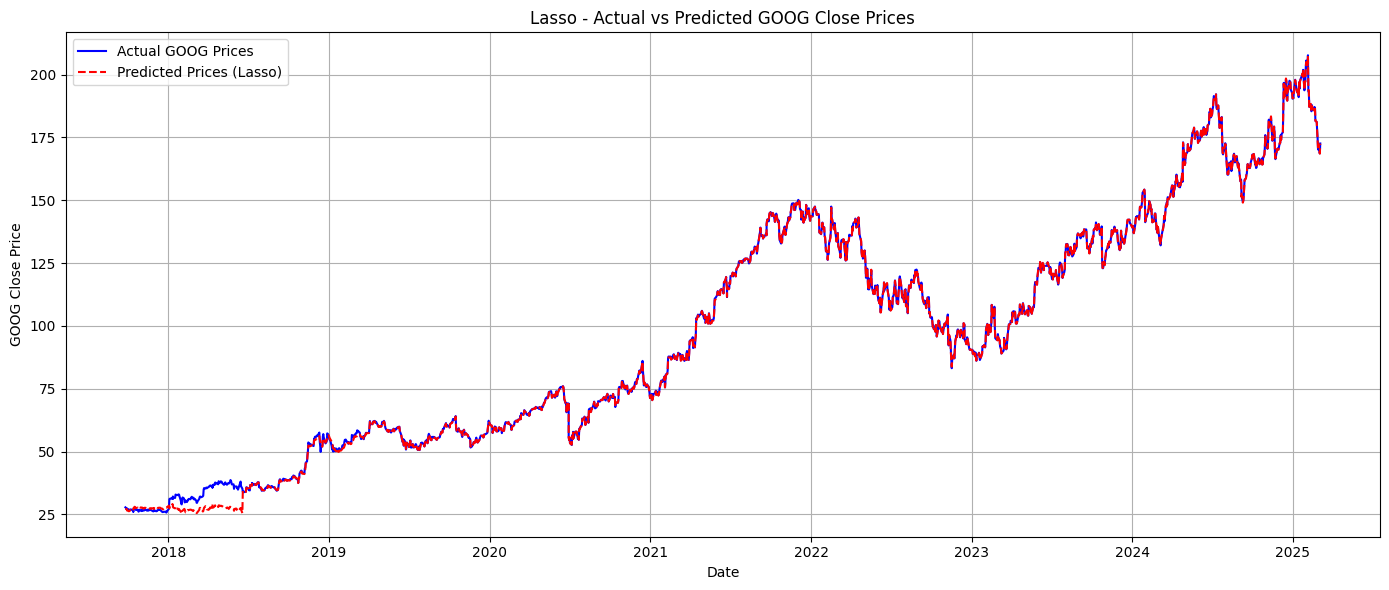

In [103]:
plt.figure(figsize=(14, 6))
plt.plot(all_dates, lasso_actuals, label='Actual GOOG Prices', color='blue')
plt.plot(all_dates, lasso_preds, label='Predicted Prices (Lasso)', color='red', linestyle='--')
plt.title('Lasso - Actual vs Predicted GOOG Close Prices')
plt.xlabel('Date')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [104]:
#metrics for Lasso training data
lasso_train_pearson_corr, _ = pearsonr(lasso_preds, lasso_actuals)
lasso_train_spearman_corr, _ = spearmanr(lasso_preds, lasso_actuals)
lasso_train_rmse = np.sqrt(mean_squared_error(lasso_actuals, lasso_preds))
lasso_train_mae = mean_absolute_error(lasso_actuals, lasso_preds)
lasso_train_mape = mean_absolute_percentage_error(lasso_actuals, lasso_preds)

print(f"Lasso Training Pearson Correlation: {lasso_train_pearson_corr:.4f}")
print(f"Lasso Training Spearman Correlation: {lasso_train_spearman_corr:.4f}")
print(f"Lasso Training RMSE: {lasso_train_rmse:.4f}")
print(f"Lasso Training MAE: {lasso_train_mae:.4f}")
print(f"Lasso Training MAPE: {lasso_train_mape:.2%}")

Lasso Training Pearson Correlation: 0.9993
Lasso Training Spearman Correlation: 0.9988
Lasso Training RMSE: 1.8641
Lasso Training MAE: 0.6136
Lasso Training MAPE: 1.55%


In [105]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)

#generating the next 15 trading dats
target = 'GOOG_adjClose'

#starting from the last known information
last_known = df_lagged.iloc[-1:].copy()

lasso_future_preds = []

last_date = pd.to_datetime(df_lagged['date'].iloc[-1])
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=15)

#loop that generates the forecast
for i in range(len(future_dates)):
    #extracting the current input
    X_input = last_known[lag_features + static_features].iloc[-1:]
    X_input = imputer.transform(X_input)

    X_scaled = scaler_X.transform(X_input)

    #predicting the nect values
    next_scaled_pred = final_lasso.predict(X_scaled)[0]
    next_pred = max(0, scaler_y.inverse_transform([[next_scaled_pred]])[0, 0])  # unscale
    lasso_future_preds.append(next_pred)

    # Recalculate rolling stats and momentum on the latest 6+1 values
    # Only recalculate rolling stats if we have at least 6 rows
    if len(last_known) >= 6:
        recent_preds = [last_known.iloc[-i][f'{target}_lag_1'] for i in range(5, -1, -1) if not pd.isna(last_known.iloc[-i][f'{target}_lag_1'])]

        if len(recent_preds) == 6:
            prices = np.array(recent_preds)
            next_row[f'{target}_roll_mean_5'] = prices[-5:].mean()
            next_row[f'{target}_roll_std_5'] = prices[-5:].std()
            next_row[f'{target}_momentum_5'] = prices[-1] - prices[-6]
            next_row[f'{target}_roc_5'] = (prices[-1] - prices[-6]) / prices[-6]

    # moving to the next value
    next_row = last_known.iloc[-1:].copy()

    for feat in static_features:
        if feat in last_known.columns:
            base_val = last_known.iloc[-1][feat]
            #adding some noise to the static feautures to make it more realistic for the forecasting
            #without this- the static feartures were outweighing the lags and plotting a straight horizontal line for the forecast
            next_row[feat] = base_val * np.random.normal(1, 0.002)

    #shifting the target lag
    for lag in range(7, 1, -1):
        next_row[f'{target}_lag_{lag}'] = last_known.iloc[-1][f'{target}_lag_{lag - 1}']
    next_row[f'{target}_lag_1'] = next_pred

    #shfting extra lags
    for feature in ['inflationRate', 'Gold_price',
                    'GOOG_stock_news_sentiment', 'NVDA_stock_news_sentiment']:
        max_lag = 60 if feature == 'inflationRate' else (
            7 if feature in ['Gold_price', 'NVDA_stock_news_sentiment'] else 5)

        for lag in range(max_lag, 1, -1):
            prev_col = f'{feature}_lag_{lag - 1}'
            curr_col = f'{feature}_lag_{lag}'
            if prev_col in last_known.columns:
                next_row[curr_col] = last_known.iloc[-1][prev_col]

        if f'{feature}_lag_1' in last_known.columns:
            next_row[f'{feature}_lag_1'] = last_known.iloc[-1][f'{feature}_lag_1']
           
    #making the new row
    last_known = pd.concat([last_known, next_row.tail(1)], ignore_index=True)


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

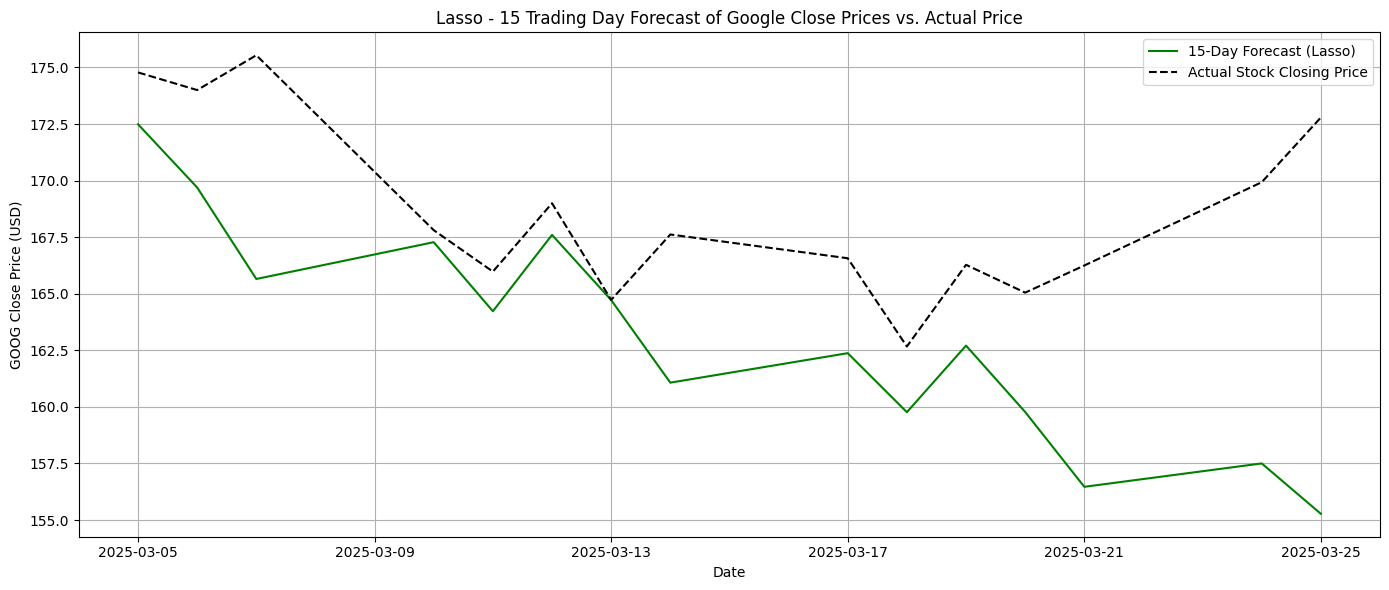

In [108]:
# Final plot: historical + forecast
plt.figure(figsize=(14, 6))
plt.plot(future_dates, lasso_future_preds, label='15-Day Forecast (Lasso)', color='green')
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('Lasso - 15 Trading Day Forecast of Google Close Prices vs. Actual Price')
plt.xlabel('Date')
plt.ylabel('GOOG Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
#finding the different metrics for evaluating the model
lasso_pearson_corr, _ = pearsonr(lasso_future_preds, close_real)
lasso_spearman_corr, _ = spearmanr(lasso_future_preds, close_real)
lasso_rmse = np.sqrt(mean_squared_error(lasso_future_preds, close_real))
lasso_mae = mean_absolute_error(lasso_future_preds, close_real)
lasso_mape = mean_absolute_percentage_error(lasso_future_preds, close_real)

print(f"Lasso Pearson Correlation: {lasso_pearson_corr:.4f}")
print(f"Lasso Spearman Correlation: {lasso_spearman_corr:.4f}")
print(f"Lasso RMSE: {lasso_rmse:.4f}")
print(f"Lasso MAE: {lasso_mae:.4f}")
print(f"Lasso MAPE: {lasso_mape:.2%}")


Lasso Pearson Correlation: 0.4062
Lasso Spearman Correlation: 0.3929
Lasso RMSE: 7.2714
Lasso MAE: 5.4920
Lasso MAPE: 3.43%


## Model 2: LSTM

In [40]:
from sklearn.preprocessing import MinMaxScaler

# lag features (and optionally external features)
lag_features = [col for col in df_lagged.columns if 'lag' in col]

features = lag_features + static_features

X = df_lagged[features].values
y = df_lagged['GOOG_adjClose'].values

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))


# Reshape into (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 timestep

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


lstm_model = Sequential()
lstm_model.add(LSTM(units=60, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train with early stopping
lstm_model.fit(
    X_reshaped, y_scaled,
    epochs=50,               
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0289
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3869e-04
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8056e-04
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7531e-04
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5853e-04
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4161e-04
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2138e-04
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1026e-04
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0616e-04
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0369e-04
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0008e-04
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9523e-04
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


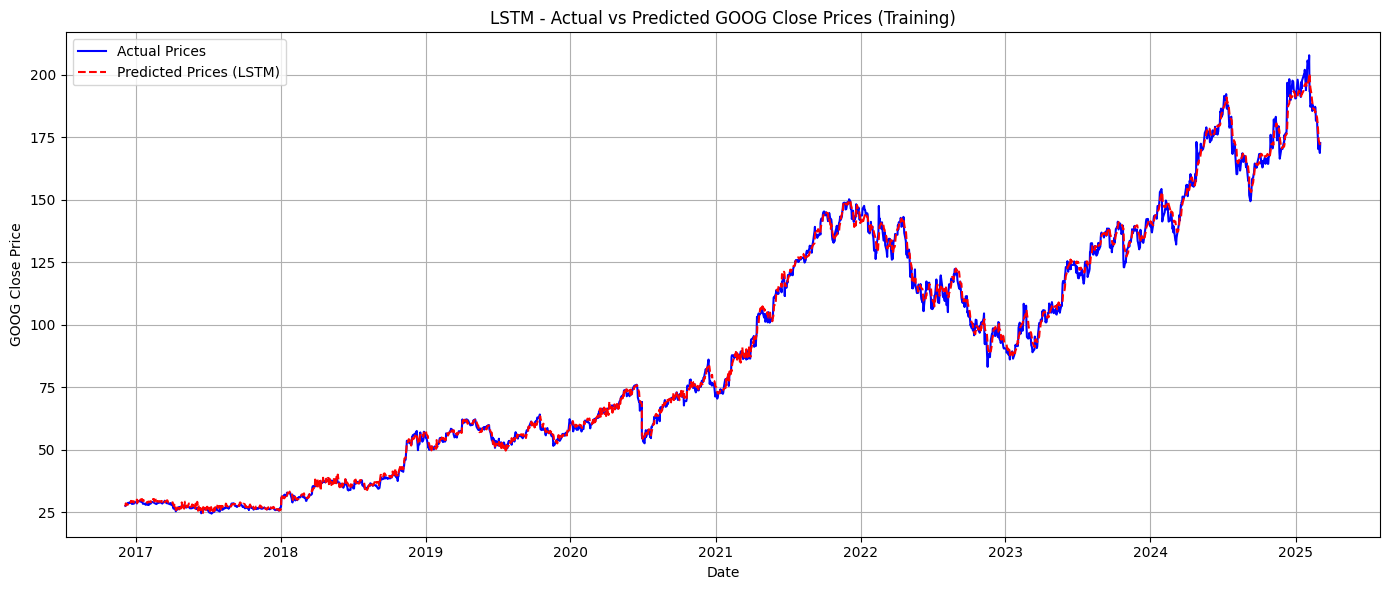

In [ ]:
#predicting on trainig data
train_preds_scaled = lstm_model.predict(X_reshaped)
train_preds = scaler_y.inverse_transform(train_preds_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).ravel()
dates = pd.to_datetime(df_lagged['date'])  # assumes Date is present

#plotting the graph
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Prices', color='blue')
plt.plot(dates, train_preds, label='Predicted Prices (LSTM)', color='red', linestyle='--')
plt.title('LSTM - Actual vs Predicted GOOG Close Prices (Training)')
plt.xlabel('Date')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [43]:
lstm_train_pearson_corr, _ = pearsonr(train_preds, y_actual)
lstm_train_spearman_corr, _ = spearmanr(train_preds, y_actual)
lstm_train_rmse = np.sqrt(mean_squared_error(y_actual, train_preds))
lstm_train_mae = mean_absolute_error(y_actual, train_preds)
lstm_train_mape = mean_absolute_percentage_error(y_actual, train_preds)

print(f"LSTM Training Pearson Correlation: {lstm_train_pearson_corr:.4f}")
print(f"LSTM Training Spearman Correlation: {lstm_train_spearman_corr:.4f}")
print(f"LSTM Training RMSE: {lstm_train_rmse:.4f}")
print(f"LSTM Training MAE: {lstm_train_mae:.4f}")
print(f"LSTM Training MAPE: {lstm_train_mape:.2%}")

LSTM Training Pearson Correlation: 0.9988
LSTM Training Spearman Correlation: 0.9984
LSTM Training RMSE: 2.3673
LSTM Training MAE: 1.6530
LSTM Training MAPE: 1.98%


In [50]:
last_input = X_scaled[:, :X_reshaped.shape[2]][-1:].copy()  # Last row of training input
lstm_future_preds = []

for _ in range(len(future_dates)):
    input_seq = last_input.reshape((1, 1, X_reshaped.shape[2]))
    next_scaled_pred = lstm_model.predict(input_seq)[0][0]
    next_pred = scaler_y.inverse_transform([[next_scaled_pred]])[0][0]
    lstm_future_preds.append(next_pred)

    # Shift and insert new prediction into first lag
    new_lag_input = np.roll(last_input, shift=1)
    #gives more realistic price movement
    new_lag_input[0, 0] = 0.80 * last_input[0, 1] + 0.15 * next_scaled_pred
    last_input = new_lag_input


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


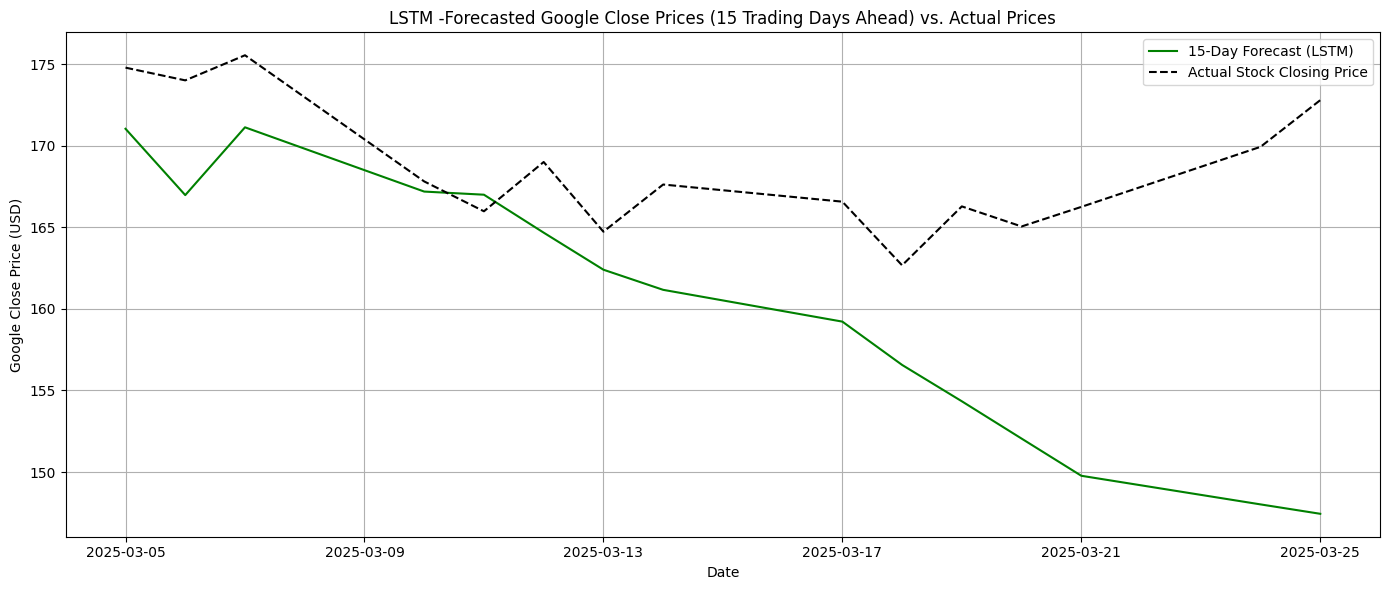

In [51]:
plt.figure(figsize=(14, 6))
plt.plot(future_dates, lstm_future_preds, label='15-Day Forecast (LSTM)', color='green')
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('LSTM -Forecasted Google Close Prices (15 Trading Days Ahead) vs. Actual Prices')
plt.xlabel('Date')
plt.ylabel('Google Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
lstm_pearson_corr, _ = pearsonr(lstm_future_preds, close_real)
lstm_spearman_corr, _ = spearmanr(lstm_future_preds, close_real)
lstm_rmse = np.sqrt(mean_squared_error(close_real, lstm_future_preds))
lstm_mae = mean_absolute_error(close_real, lstm_future_preds)
lstm_mape = mean_absolute_percentage_error(close_real, lstm_future_preds)

print(f"LSTM Pearson Correlation: {lstm_pearson_corr:.4f}")
print(f"LSTM Spearman Correlation: {lstm_spearman_corr:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM MAPE: {lstm_mape:.2%}")

LSTM Pearson Correlation: 0.3718
LSTM Spearman Correlation: 0.3464
LSTM RMSE: 11.3926
LSTM MAE: 8.8042
LSTM MAPE: 5.21%


## Model 3: Bi-LSTM

In [53]:
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
from sklearn.model_selection import train_test_split

y_scaled = y_scaled.ravel()

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_scaled, test_size=0.2, shuffle=False)



In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=50), input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
bilstm_model.add(Dense(1))
bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0271 - val_loss: 0.0048
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.5338e-04 - val_loss: 0.0031
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7646e-04 - val_loss: 0.0031
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6610e-04 - val_loss: 0.0022
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3915e-04 - val_loss: 0.0013
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9504e-04 - val_loss: 8.9902e-04
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6577e-04 - val_loss: 7.1073e-04
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6144e-04 - val_loss: 6.2856e-04
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5964e-04 - val_loss: 5.9114e-04
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5755e-04 - val_loss: 5.7930e-04
Epoch 12/50
54/54 ━━━━━━━

In [56]:
y_train_pred = bilstm_model.predict(X_train)
y_val_pred = bilstm_model.predict(X_val)


y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()




54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


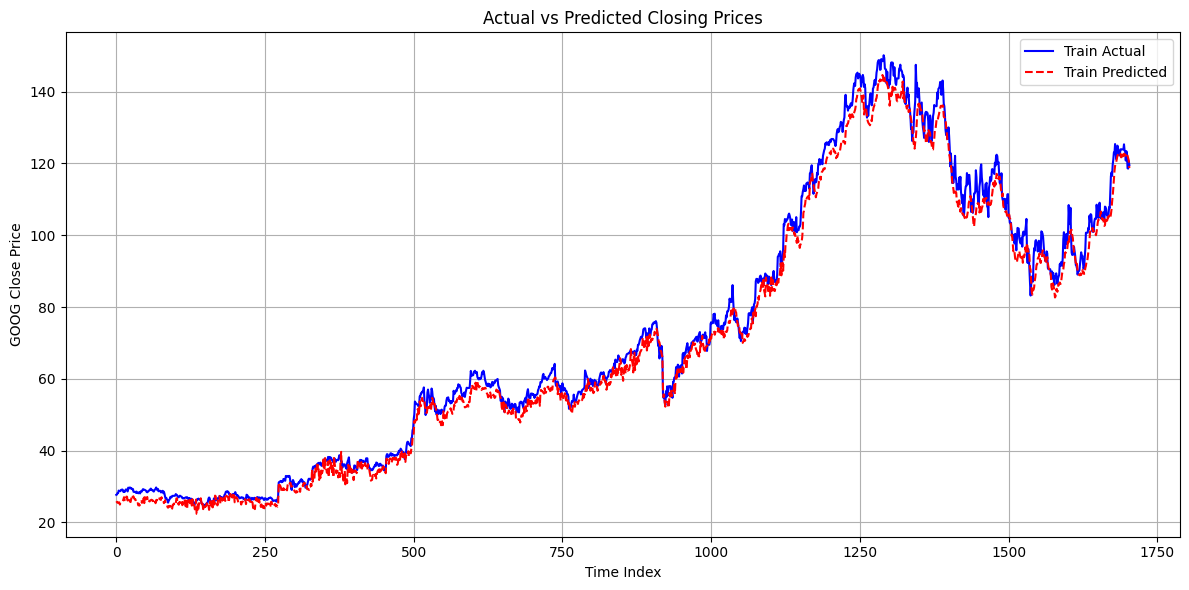

In [57]:
plt.figure(figsize=(12, 6))

# Plot training set
plt.plot(y_train_actual, label='Train Actual', color='blue')
plt.plot(y_train_pred, label='Train Predicted', linestyle='--', color='red')

# Plot validation set (offset to start after training set)
val_start_idx = len(y_train_actual)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Index')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
bilstm_train_pearson_corr, _ = pearsonr(y_train_pred, y_train_actual)
bilstm_train_spearman_corr, _ = spearmanr(y_train_pred, y_train_actual)
bilstm_train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
bilstm_train_mae = mean_absolute_error(y_train_actual, y_train_pred)
bilstm_train_mape = mean_absolute_percentage_error(y_train_actual, y_train_pred)

print(f"BiLSTM Training Pearson Correlation:  {bilstm_train_pearson_corr:.4f}")
print(f"BiLSTM Training Spearman Correlation: {bilstm_train_spearman_corr:.4f}")
print(f"BiLSTM Training RMSE:                 {bilstm_train_rmse:.4f}")
print(f"BiLSTM Training MAE:                  {bilstm_train_mae:.4f}")
print(f"BiLSTM Training MAPE:                 {bilstm_train_mape:.2%}")

BiLSTM Training Pearson Correlation:  0.9979
BiLSTM Training Spearman Correlation: 0.9957
BiLSTM Training RMSE:                 3.6854
BiLSTM Training MAE:                  2.9365
BiLSTM Training MAPE:                 4.43%


In [64]:
last_input = X_scaled[-1:].copy()
bilstm_future_preds_scaled = []

for _ in range(len(future_dates)):
    input_seq = last_input.reshape((1, 1, X_scaled.shape[1]))  # shape = (1, 1, features)
    next_scaled_pred = bilstm_model.predict(input_seq)[0][0]
    bilstm_future_preds_scaled.append(next_scaled_pred)

    # Shift and update lags (simulate next input)
    new_lag_input = np.roll(last_input, shift=1)
    new_lag_input[0, 0] = 0.80 * last_input[0, 1] + 0.15 * next_scaled_pred
    last_input = new_lag_input

#unscaling the y values
bilstm_future_preds = scaler_y.inverse_transform(np.array(bilstm_future_preds_scaled).reshape(-1, 1)).ravel()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


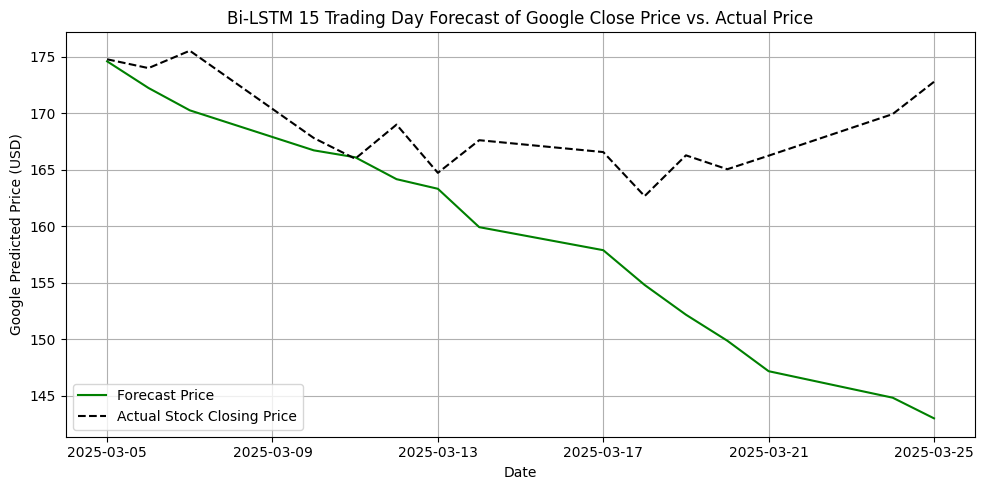

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(future_dates, bilstm_future_preds, label='Forecast Price', color="green")
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('Bi-LSTM 15 Trading Day Forecast of Google Close Price vs. Actual Price')
plt.xlabel('Date')
plt.ylabel('Google Predicted Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [66]:
#checking the pearson and spearman correlations 
bilstm_pearson_corr, _ = pearsonr(bilstm_future_preds, close_real)
bilstm_spearman_corr, _ = spearmanr(bilstm_future_preds, close_real)
bilstm_rmse = np.sqrt(mean_squared_error(close_real, bilstm_future_preds))
bilstm_mae = mean_absolute_error(close_real, bilstm_future_preds)
bilstm_mape = mean_absolute_percentage_error(close_real, bilstm_future_preds)

print(f"BiLSTM Pearson Correlation: {bilstm_pearson_corr:.4f}")
print(f"BiLSTM Spearman Correlation: {bilstm_spearman_corr:.4f}")
print(f"BiLSTM RMSE:                 {bilstm_rmse:.4f}")
print(f"BiLSTM MAE:                  {bilstm_mae:.4f}")
print(f"BiLSTM MAPE:                 {bilstm_mape:.2%}")

BiLSTM Pearson Correlation: 0.3943
BiLSTM Spearman Correlation: 0.3821
BiLSTM RMSE:                 13.0761
BiLSTM MAE:                  9.4781
BiLSTM MAPE:                 5.62%


## SARIMAX

In [110]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [111]:
#checking which columns are the most correlated with the close price (only numeric columns)
#create a copy with only numeric columns
numeric_df = google_data.select_dtypes(include='number').copy()

#crop rows with NaNs to avoid correlation issues
numeric_df = numeric_df.dropna()

#compute correlation with target
correlations = numeric_df.corr()['GOOG_adjClose'].drop('GOOG_adjClose').sort_values(ascending=False)

#display the most correlated features
print("Top features most correlated with GOOG_adjClose:")
print(correlations)


Top features most correlated with GOOG_adjClose:
GOOG_adjLow              0.999846
GOOG_adjOpen             0.999607
dema                     0.997682
sma                      0.997682
ema                      0.997682
                           ...   
CHFUSD_change           -0.824316
CHFUSD_changeOverTime   -0.825882
CHFUSD_changePercent    -0.825882
JPYUSD_change           -0.829750
standardDeviation             NaN
Name: GOOG_adjClose, Length: 152, dtype: float64


In [ ]:
#seeing which feature have a high correlation
high_corr_features = correlations.drop(['GOOG_adjLow', 'GOOG_adjOpen', 'year'], errors='ignore')
high_corr_features = high_corr_features[high_corr_features.abs() > 0.85].index.tolist()

print("\nFeatures with |correlation| > 0.85:")
print(high_corr_features)



Features with |correlation| > 0.85:
['dema', 'sma', 'ema', 'tema', 'wma', 'Gold_open', 'Gold_close', 'Gold_price', 'Copper_price', 'Copper_close', 'Copper_open']


In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

#seeing which features are the most important (only numerical)
#getting the numerical data
numeric_df = google_data.select_dtypes(include='number').dropna()

rf_X = numeric_df.drop(columns=['GOOG_adjClose'])
rf_y = numeric_df['GOOG_adjClose']

#scale features
scaler = StandardScaler()
rf_X_scaled = scaler.fit_transform(rf_X)

#splitting into train and test
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X_scaled, rf_y, test_size=0.2, random_state=42)

#random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(rf_X_train, rf_y_train)

#checking feature importance
importances = rf.feature_importances_
feature_names = rf_X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Top Random Forest feature importances:")
print(feat_imp.head(20))


Top Random Forest feature importances:
GOOG_adjLow        0.585465
dema               0.097761
wma                0.097558
ema                0.095863
sma                0.066519
tema               0.049916
GOOG_adjOpen       0.004087
GOOG_close         0.001967
GOOG_low           0.000446
GOOG_open          0.000212
GOOG_high          0.000126
Lithium_price      0.000023
month6             0.000013
Lithium_open       0.000002
Copper_close       0.000002
Palladium_close    0.000001
CADUSD_vwap        0.000001
CNHUSD_open        0.000001
Lithium_close      0.000001
Copper_open        0.000001
dtype: float64


In [114]:
#defining feature for the model
sar_y = pd.to_numeric(google_data['GOOG_adjClose'], errors='coerce')
sar_y = sar_y.dropna()

#picking exogeneous variables
exog_features = ['technologyChangesPercentage',
    'Gold_price',
    'Silver_price',
    'JPYUSD_close',
    'EURUSD_close',
    'pe',
    'ema', 'williams',
    'GOOG_stock_news_sentiment',
    'GOOG_press_release_sentiment',
    'NVDA_adjClose',
    'NVDA_stock_news_sentiment',
    'NVDA_press_release_sentiment'
]

X_exog = google_data[exog_features].copy()

#sentiment map
sentiment_map = {
    'very_negative': -1,
    'weakly_negative': -0.5,
    'neutral': 0,
    'weakly_positive': 0.5,
    'very_positive': 1
}

#applying the map to the sentiment columns
for col in X_exog.columns:
    if 'sentiment' in col:
        X_exog[col] = X_exog[col].map(sentiment_map)

#convert all to numeric (in case mapping failed or there are still objects)
X_exog = X_exog.apply(pd.to_numeric, errors='coerce')

#filling in any missing values
X_exog = X_exog.fillna(method='ffill').fillna(method='bfill')

X_exog = X_exog.loc[sar_y.index]
assert len(X_exog) == len(sar_y)


C:\Users\mckay\AppData\Local\Temp\ipykernel_17300\1133214418.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_exog = X_exog.fillna(method='ffill').fillna(method='bfill')


In [115]:
#SARIMAX model
sar_model = SARIMAX(
    sar_y,
    exog=X_exog,
    order=(2, 1, 2),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sar_results = sar_model.fit(disp=False)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


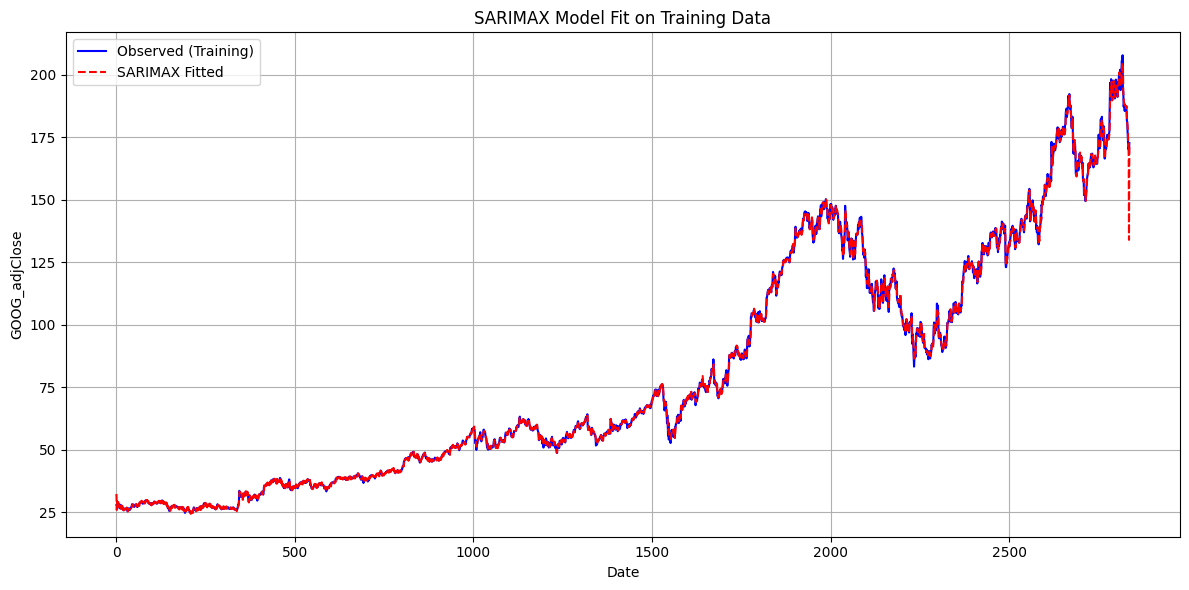

In [116]:
#training results 
fitted_values = sar_results.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(sar_y, label='Observed (Training)', color='blue')
plt.plot(fitted_values, label='SARIMAX Fitted', color='red', linestyle='--')
plt.title("SARIMAX Model Fit on Training Data")
plt.xlabel("Date")
plt.ylabel("GOOG_adjClose")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [117]:
sar_train_pearson_corr, _ = pearsonr(sar_results.fittedvalues, sar_y)
sar_train_spearman_corr, _ = spearmanr(sar_results.fittedvalues, sar_y)
sar_train_rmse = np.sqrt(mean_squared_error(sar_y, sar_results.fittedvalues))
sar_train_mae = mean_absolute_error(sar_y, sar_results.fittedvalues)
sar_train_mape = mean_absolute_percentage_error(sar_y, sar_results.fittedvalues)

print(f"SARIMAX Training Pearson Correlation:  {sar_train_pearson_corr:.4f}")
print(f"SARIMAX Training Spearman Correlation: {sar_train_spearman_corr:.4f}")
print(f"SARIMAX Training RMSE:                 {sar_train_rmse:.4f}")
print(f"SARIMAX Training MAE:                  {sar_train_mae:.4f}")
print(f"SARIMAX Training MAPE:                 {sar_train_mape:.2%}")

SARIMAX Training Pearson Correlation:  0.9997
SARIMAX Training Spearman Correlation: 0.9996
SARIMAX Training RMSE:                 1.2048
SARIMAX Training MAE:                  0.6382
SARIMAX Training MAPE:                 0.84%


In [118]:
# Create future exogenous input like LSTM (repeating last known values)
last_known = X_exog.iloc[-1]
sar_future_exog = pd.DataFrame(
    {col: [last_known[col]] * len(future_dates) for col in X_exog.columns},
    index=future_dates
)

# Forecast 15 future points
sar_forecast = sar_results.get_forecast(steps=len(future_dates), exog=sar_future_exog)
sar_forecast_mean = sar_forecast.predicted_mean


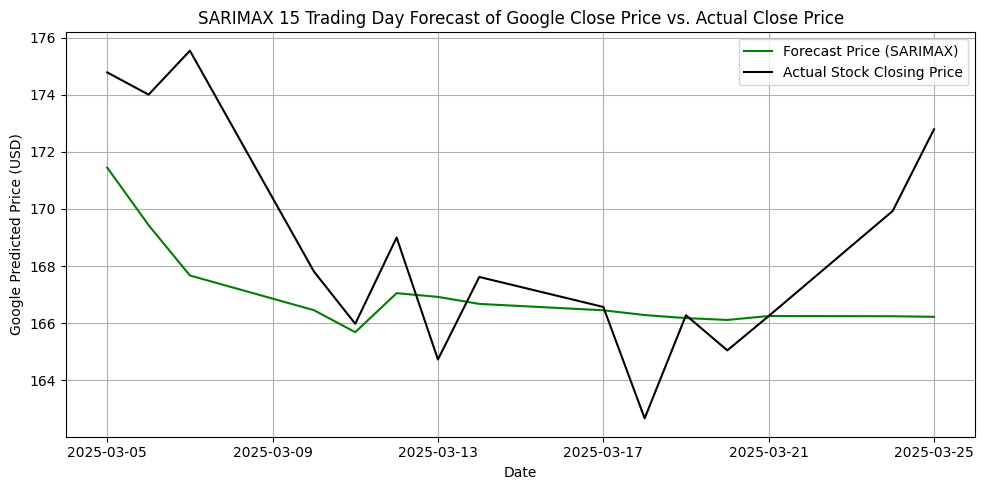

In [119]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, sar_forecast_mean, label='Forecast Price (SARIMAX)', color='green')
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label='Actual Stock Closing Price', color='black')
plt.title('SARIMAX 15 Trading Day Forecast of Google Close Price vs. Actual Close Price')
plt.xlabel('Date')
plt.ylabel('Google Predicted Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [120]:
#checking the pearson and spearman correlations 
sar_pearson_corr, _ = pearsonr(sar_forecast_mean, close_real)
sar_spearman_corr, _ = spearmanr(sar_forecast_mean, close_real)
sar_rmse = np.sqrt(mean_squared_error(close_real, sar_forecast_mean))
sar_mae = mean_absolute_error(close_real, sar_forecast_mean)
sar_mape = mean_absolute_percentage_error(close_real, sar_forecast_mean)

print(f"SARIMAX Pearson Correlation:  {sar_pearson_corr:.4f}")
print(f"SARIMAX Spearman Correlation: {sar_spearman_corr:.4f}")
print(f"SARIMAX RMSE:                 {sar_rmse:.4f}")
print(f"SARIMAX MAE:                  {sar_mae:.4f}")
print(f"SARIMAX MAPE:                 {sar_mape:.2%}")

SARIMAX Pearson Correlation:  0.6828
SARIMAX Spearman Correlation: 0.5500
SARIMAX RMSE:                 3.4276
SARIMAX MAE:                  2.5102
SARIMAX MAPE:                 1.47%
